In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import Cursor

In [3]:
# Загружаем данные из файлов
contacts_df = pd.read_parquet('drive/MyDrive/Final_Project_ICH/Clean_file/ContactsClean.parquet')
calls_df = pd.read_parquet('drive/MyDrive/Final_Project_ICH/Clean_file/CallsClean.parquet')
spend_df = pd.read_parquet('drive/MyDrive/Final_Project_ICH/Clean_file/SpendClean.parquet')
deals_df = pd.read_parquet('drive/MyDrive/Final_Project_ICH/Clean_file/DealsClean.parquet')

# **Агрегация данных:**

Подсчет общего дохода и количества сделок для каждого продукта.
Подсчет затрат на маркетинг для каждого продукта на основе кампаний и источников.
Расчет ключевых метрик юнит-экономики:

Выручка на единицу продукта (Revenue per Unit).
Затраты на единицу продукта (Cost per Unit).
Маржинальный доход (Contribution Margin).
Стоимость привлечения клиента (CAC).
Соотношение LTV/CAC.
Анализ и выводы:

Определение прибыльности каждого продукта и предоставление рекомендаций по оптимизации.

## Расчет юнит экономики для всего бизнесса


In [4]:
# Копия данных
deals_df = deals_df.copy()
spend_df = spend_df.copy()
contacts_df = contacts_df.copy()

# Очистка и стандартизация
deals_df['Product'] = deals_df['Product'].astype(str).str.strip().str.title()

# Преобразование нужных колонок в числовые
for col in ['Initial Amount Paid', 'Offer Total Amount', 'Course duration', 'Months of study']:
    deals_df[col] = pd.to_numeric(deals_df[col], errors='coerce')

# Расчёт AOV и RI для всех сделок

deals_df['AOVi'] = (
    deals_df['Initial Amount Paid'] +
    ((deals_df['Offer Total Amount'] - deals_df['Initial Amount Paid']) /
     (deals_df['Course duration'] - 1)) *
    (deals_df['Months of study'] - 1)
) / deals_df['Months of study']

deals_df["RI"] = deals_df['AOVi'] * deals_df['Months of study']

deals_df["AOV"] = deals_df['RI'][deals_df['Stage']=='Payment Done'].sum()/deals_df['Months of study'][deals_df['Stage']=='Payment Done'].sum()

# Фильтрация успешных оплат
paid = deals_df[deals_df['Stage'] == 'Payment Done'].copy()

# Расчёт юнит-экономики по всему бизнесу
UA = contacts_df['Id'].nunique()
B = deals_df['Contact Name'][deals_df['Months of study'] > 0].nunique()
C1 = B / UA if UA else 0
AC = spend_df['Spend'].sum()
CPA = AC / UA if UA else 0
T = deals_df['Months of study'].sum()
AOV = paid['AOV'].mean()
APC = T / B if B else 0
CAC = CPA * APC
Gross_Revenue = paid['RI'].sum()
CLTV = AOV * APC
LTV = CLTV * C1
CM = (LTV - CPA) * UA

# Финальный словарь
unit_economy_summary = {
    'UA': UA,
        'Buyers': B,
        'C1': f"{round(C1 * 100, 2)}%",
        'AC': round(AC, 2),
        'CPA': round(CPA, 2),
        'T': round(T, 2),
        'AOV': round(AOV, 2),
        'APC': round(APC, 2),
        'CAC': round(CAC, 2),
        'CLTV': round(CLTV, 2),
        'LTV': round(LTV, 2),
        'Gross Revenue': round(Gross_Revenue, 2),
        'CM': round(CM, 2)
}

# Преобразование словаря в DataFrame
unit_economy_df = pd.DataFrame([unit_economy_summary])
#unit_economy_df = pd.DataFrame(unit_economy_summary.items(), columns=['Метрика', 'Значение'])

unit_economy_df.style.set_table_styles([
    {"selector": "th", "props": [("padding", "50px"), ("text-align", "center"), ("min-width", "500px")]},
    {"selector": "td", "props": [("padding", "55px"), ("text-align", "center"), ("min-width", "500px")]}
])

# Отображение таблицы
unit_economy_df

,UA,Buyers,C1,AC,CPA,T,AOV,APC,CAC,CLTV,LTV,Gross Revenue,CM
0,18548,3187,17.18%,148915.24,8.03,11313.0,938.45,3.55,28.5,3331.25,572.39,10592305.08,10467789.59


# Расчет метрик юнит-экономики с сегментацией по продуктам

In [5]:
# Удалить не нужные типы продуктов
products_to_remove = ['Find Yourself In It', 'Data Analytics', 'None']
deals_df = deals_df[~deals_df['Product'].isin(products_to_remove)]

In [6]:
# Копия данных
deals_df = deals_df.copy()
spend_df = spend_df.copy()
contacts_df = contacts_df.copy()

# Очистка и стандартизация
deals_df['Product'] = deals_df['Product'].astype(str).str.strip().str.title()

# Преобразование нужных колонок в числовые
for col in ['Initial Amount Paid', 'Offer Total Amount', 'Course duration', 'Months of study']:
    deals_df[col] = pd.to_numeric(deals_df[col], errors='coerce')

# Расчёт AOV и RI
deals_df['AOVi'] = (
    deals_df['Initial Amount Paid'] +
    ((deals_df['Offer Total Amount'] - deals_df['Initial Amount Paid']) /
     (deals_df['Course duration'] - 1)) *
    (deals_df['Months of study'] - 1)
) / deals_df['Months of study']

deals_df["RI"] = deals_df['AOVi'] * deals_df['Months of study']

deals_df["AOV"] = deals_df['RI'][deals_df['Stage']=='Payment Done'].sum()/deals_df['Months of study'][deals_df['Stage']=='Payment Done'].sum()

# Фильтрация успешных оплат
paid = deals_df[deals_df['Stage'] == 'Payment Done'].copy()

# Сегментация по продуктам
results = []

for product, df in deals_df.groupby('Product'):
    df = df.copy()  # важно!

    UA = contacts_df['Id'].nunique()
    B = df[df['Months of study'] > 0]['Contact Name'].nunique()
    C1 = B / UA if UA else 0
    AC = spend_df['Spend'].sum()
    CPA = AC / UA if UA else 0
    T = df['Months of study'].sum()

    # <-- ключевая часть: считаем AOV на основе текущего df
    aov_numerator = df[df['Stage'] == 'Payment Done']['Initial Amount Paid'].sum()
    aov_denominator = df[df['Stage'] == 'Payment Done']['Months of study'].sum()
    AOV = aov_numerator / aov_denominator if aov_denominator else 0

    df["AOV"] = AOV
    df["RI"] = df["AOVi"] * df["Months of study"]

    APC = T / B if B else 0
    CAC = CPA * APC
    Gross_Revenue = df[df['Stage'] == 'Payment Done']["RI"].sum()
    CLTV = AOV * APC
    LTV = CLTV * C1
    CM = UA * (LTV - CPA)

    results.append({
        'Product': product,
        'UA': UA,
        'Bayers': B,
        'C1': f"{round(C1 * 100, 2)}%",
        'AC': round(AC, 2),
        'CPA': round(CPA, 2),
        'T': round(T, 2),
        'AOV': round(AOV, 2),
        'APC': round(APC, 2),
        'CAC': round(CAC, 2),
        'CLTV': round(CLTV, 2),
        'LTV': round(LTV, 2),
        'Gross Revenue': round(Gross_Revenue, 2),
        'CM': round(CM, 2)
    })


# Финальный DataFrame
unit_economy_by_product = pd.DataFrame(results)
unit_economy_by_product.style.set_table_styles([
    {"selector": "th", "props": [("padding", "50px"), ("text-align", "center"), ("min-width", "500px")]},
    {"selector": "td", "props": [("padding", "55px"), ("text-align", "center"), ("min-width", "500px")]}
])
unit_economy_by_product

,Product,UA,Bayers,C1,AC,CPA,T,AOV,APC,CAC,CLTV,LTV,Gross Revenue,CM
0,Digital Marketing,18548,1773,9.56%,148915.24,8.03,6658.0,319.38,3.76,30.15,1199.36,114.65,6186830.98,1977546.10
1,Ux/Ui Design,18548,901,4.86%,148915.24,8.03,3038.0,371.78,3.37,27.07,1253.57,60.89,2919088.88,980548.27
2,Web Developer,18548,516,2.78%,148915.24,8.03,1592.0,362.48,3.09,24.77,1118.34,31.11,1486385.22,428147.14


# Анализ, какие метрики при увеличении на 5% сильнее всего влияют на прибыль (CM) по каждому продукту.

In [7]:
# Копия данных
deals_df = deals_df.copy()
spend_df = spend_df.copy()
contacts_df = contacts_df.copy()

# Очистка и стандартизация
deals_df['Product'] = deals_df['Product'].astype(str).str.strip().str.title()

# Преобразование нужных колонок в числовые
for col in ['Initial Amount Paid', 'Offer Total Amount', 'Course duration', 'Months of study']:
    deals_df[col] = pd.to_numeric(deals_df[col], errors='coerce')

# Расчет AOV

deals_df['AOVi'] = (
    deals_df['Initial Amount Paid'] +
    ((deals_df['Offer Total Amount'] - deals_df['Initial Amount Paid']) /
     (deals_df['Course duration'] - 1)) *
    (deals_df['Months of study'] - 1)
) / deals_df['Months of study']

deals_df["RI"] = deals_df['AOVi'] * deals_df['Months of study']

deals_df["AOV"] = deals_df['RI'][deals_df['Stage']=='Payment Done'].sum()/deals_df['Months of study'][deals_df['Stage']=='Payment Done'].sum()

# Сегментация по продуктам
results = []

for product, df in deals_df.groupby('Product'):
    df = df.copy()
    UA = contacts_df['Id'].nunique()
    B = df[df['Months of study'] > 0]['Contact Name'].nunique()
    C1 = B / UA if UA else 0
    AC = spend_df['Spend'].sum()
    CPA = AC / UA if UA else 0
    T = df['Months of study'].sum()
    aov_numerator = df[df['Stage'] == 'Payment Done']['Initial Amount Paid'].sum()
    aov_denominator = df[df['Stage'] == 'Payment Done']['Months of study'].sum()
    AOV = aov_numerator / aov_denominator if aov_denominator else 0
    df["AOV"] = AOV
    df["RI"] = df["AOVi"] * df["Months of study"]
    APC = T / B if B else 0
    CAC = CPA * APC
    Gross_Revenue = df[df['Stage'] == 'Payment Done']["RI"].sum()
    CLTV = AOV * APC
    LTV = CLTV * C1
    CM = UA * (LTV - CPA)

    results.append({
        'Product': product,
        'UA (Unique Users)': UA,
        'B (Buyers)': B,
        'C1 (Conversion Rate %)': round(C1 * 100, 2),
        'AC (Marketing Budget)': round(AC, 2),
        'CPA (Cost Per Acquisition)': round(CPA, 2),
        'T (Total Months Paid)': round(T, 2),
        'AOV (Average Order Value)': round(AOV, 2),
        'APC (Avg Purchases per Customer)': round(APC, 2),
        'CAC (Customer Acquisition Cost)': round(CAC, 2),
        'CLTV (Customer Lifetime Value)': round(CLTV, 2),
        'LTV (Lifetime Value)': round(LTV, 2),
        'Gross Revenue': round(Gross_Revenue, 2),
        'CM (Contribution Margin)': round(CM, 2)
    })

# Финальный DataFrame
unit_economy_by_product = pd.DataFrame(results)

# Теперь продолжаем: расчёт влияния +5% по метрикам
df = unit_economy_by_product.copy()
df = df[df['Product'] != 'Total'].copy()

metrics_to_adjust = [
    'C1 (Conversion Rate %)',
    'AOV (Average Order Value)',
    'APC (Avg Purchases per Customer)',
    'CPA (Cost Per Acquisition)'
]

impact_results = []

for _, row in df.iterrows():
    base_ua = row['UA (Unique Users)']
    base_c1 = row['C1 (Conversion Rate %)'] / 100
    base_aov = row['AOV (Average Order Value)']
    base_apc = row['APC (Avg Purchases per Customer)']
    base_cpa = row['CPA (Cost Per Acquisition)']

    base_cltv = base_aov * base_apc
    base_ltv = base_cltv * base_c1
    base_cm = base_ua * (base_ltv - base_cpa)

    impacts = {}

    for metric in metrics_to_adjust:
        c1 = base_c1
        aov = base_aov
        apc = base_apc
        cpa = base_cpa

        if metric == 'C1 (Conversion Rate %)':
            c1 *= 1.05
        elif metric == 'AOV (Average Order Value)':
            aov *= 1.05
        elif metric == 'APC (Avg Purchases per Customer)':
            apc *= 1.05
        elif metric == 'CPA (Cost Per Acquisition)':
            cpa *= 1.05

        new_cltv = aov * apc
        new_ltv = new_cltv * c1
        new_cm = base_ua * (new_ltv - cpa)

        impacts[metric] = round(new_cm - base_cm, 2)

    max_metric = max(impacts, key=impacts.get)
    max_value = impacts[max_metric]

    impact_results.append({
        'Product': row['Product'],
        'Макс. влияющая метрика (при +5%)': max_metric,
        'Прирост прибыли (CM)': max_value,
        **impacts
    })

impact_df = pd.DataFrame(impact_results)

impact_df

,Product,Макс. влияющая метрика (при +5%),Прирост прибыли (CM),C1 (Conversion Rate %),AOV (Average Order Value),APC (Avg Purchases per Customer),CPA (Cost Per Acquisition)
0,Digital Marketing,C1 (Conversion Rate %),106468.36,106468.36,106468.36,106468.36,-7447.02
1,Ux/Ui Design,C1 (Conversion Rate %),56470.19,56470.19,56470.19,56470.19,-7447.02
2,Web Developer,C1 (Conversion Rate %),28877.16,28877.16,28877.16,28877.16,-7447.02


In [8]:
# Сценарии увеличения
scenarios = [0.05, 0.10, 0.20]
metrics_to_adjust = [
    'C1 (Conversion Rate %)',
    'AOV (Average Order Value)',
    'APC (Avg Purchases per Customer)',
    'CPA (Cost Per Acquisition)'
]

# Подготовка таблиц для анализа по всем продуктам и всем метрикам
sensitivity_results = []

for _, row in df.iterrows():
    base_ua = row['UA (Unique Users)']
    base_c1 = row['C1 (Conversion Rate %)'] / 100
    base_aov = row['AOV (Average Order Value)']
    base_apc = row['APC (Avg Purchases per Customer)']
    base_cpa = row['CPA (Cost Per Acquisition)']
    base_cltv = base_aov * base_apc
    base_ltv = base_cltv * base_c1
    base_cm = base_ua * (base_ltv - base_cpa)

    for metric in metrics_to_adjust:
        for scenario in scenarios:
            c1 = base_c1
            aov = base_aov
            apc = base_apc
            cpa = base_cpa

            if metric == 'C1 (Conversion Rate %)':
                c1 *= (1 + scenario)
            elif metric == 'AOV (Average Order Value)':
                aov *= (1 + scenario)
            elif metric == 'APC (Avg Purchases per Customer)':
                apc *= (1 + scenario)
            elif metric == 'CPA (Cost Per Acquisition)':
                cpa *= (1 + scenario)

            new_cltv = aov * apc
            new_ltv = new_cltv * c1
            new_cm = base_ua * (new_ltv - cpa)

            sensitivity_results.append({
                'Product': row['Product'],
                'Metric': metric,
                'Scenario': f'+{int(scenario * 100)}%',
                'CM Change': round(new_cm - base_cm, 2)
            })

# Преобразуем в DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results)

# Теперь создаем сравнение по 2–3 продуктам
selected_products = ['Ux/Ui Design', 'Digital Marketing', 'Data Analytics']
comparison_df = sensitivity_df[sensitivity_df['Product'].isin(selected_products)]

comparison_df

,Product,Metric,Scenario,CM Change
0,Digital Marketing,C1 (Conversion Rate %),+5%,106468.36
1,Digital Marketing,C1 (Conversion Rate %),+10%,212936.71
2,Digital Marketing,C1 (Conversion Rate %),+20%,425873.42
3,Digital Marketing,AOV (Average Order Value),+5%,106468.36
4,Digital Marketing,AOV (Average Order Value),+10%,212936.71
5,Digital Marketing,AOV (Average Order Value),+20%,425873.42
6,Digital Marketing,APC (Avg Purchases per Customer),+5%,106468.36
7,Digital Marketing,APC (Avg Purchases per Customer),+10%,212936.71
8,Digital Marketing,APC (Avg Purchases per Customer),+20%,425873.42
9,Digital Marketing,CPA (Cost Per Acquisition),+5%,-7447.02


In [9]:
# Преобразование нужных колонок
for col in ['Initial Amount Paid', 'Offer Total Amount', 'Course duration', 'Months of study']:
    deals_df[col] = pd.to_numeric(deals_df[col], errors='coerce')

# Расчет AOV и RI
aov_value = deals_df.loc[deals_df['Stage'] == 'Payment Done', 'Initial Amount Paid'].sum() / \
            deals_df.loc[deals_df['Stage'] == 'Payment Done', 'Months of study'].sum()
deals_df['AOV'] = aov_value
deals_df['RI'] = deals_df['AOV'] * deals_df['Months of study']

# Общие бизнес-метрики
UA = contacts_df['Id'].nunique()
AC = spend_df['Spend'].sum()
CPA = AC / UA if UA else 0
B = deals_df[deals_df['Months of study'] > 0]['Contact Name'].nunique()
C1 = B / UA if UA else 0
T = deals_df['Months of study'].sum()
AOV = aov_value
APC = T / B if B else 0
CLTV = AOV * APC
LTV = CLTV * C1
CAC = CPA * APC
CM = UA * (LTV - CPA)

# Строим дерево с факт. значениями
import graphviz

def round2(val): return round(val, 2)

dot = graphviz.Digraph(format='png')
dot.attr(rankdir='TB', size='10')

dot.node('UA', f'UA (Users)\n{UA}')
dot.node('C1', f'C1 = B / UA\n{round2(C1)}')
dot.node('B', f'B (Buyers)\n{B}')
dot.node('AC', f'AC (Marketing Budget)\n{round2(AC)}')
dot.node('CPA', f'CPA = AC / UA\n{round2(CPA)}')

dot.node('AOV', f'AOV = Revenue / Months\n{round2(AOV)}')
dot.node('APC', f'APC = Total Months / Buyers\n{round2(APC)}')
dot.node('CLTV', f'CLTV = AOV × APC\n{round2(CLTV)}')
dot.node('LTV', f'LTV = CLTV × C1\n{round2(LTV)}')
dot.node('CAC', f'CAC = CPA × APC\n{round2(CAC)}')

dot.node('CM', f'CM = UA × (LTV - CPA)\n{round2(CM)}')
dot.node('GR', f'GR = ∑RI\n{round2(deals_df["RI"].sum())}')

# Связи
dot.edges([('UA', 'C1'), ('C1', 'B'), ('UA', 'CPA'), ('CPA', 'CAC'), ('AC', 'CPA')])
dot.edge('B', 'APC')
dot.edge('AOV', 'CLTV')
dot.edge('APC', 'CLTV')
dot.edge('CLTV', 'LTV')
dot.edge('C1', 'LTV')
dot.edge('LTV', 'CM')
dot.edge('CPA', 'CM')
dot.edge('APC', 'CAC')
dot.edge('GR', 'CM')

# # Визуализация
dot.render('/mnt/data/unit_economy_tree_fact.png', cleanup=False)
from IPython.display import Image
Image('/mnt/data/unit_economy_tree_fact.png')


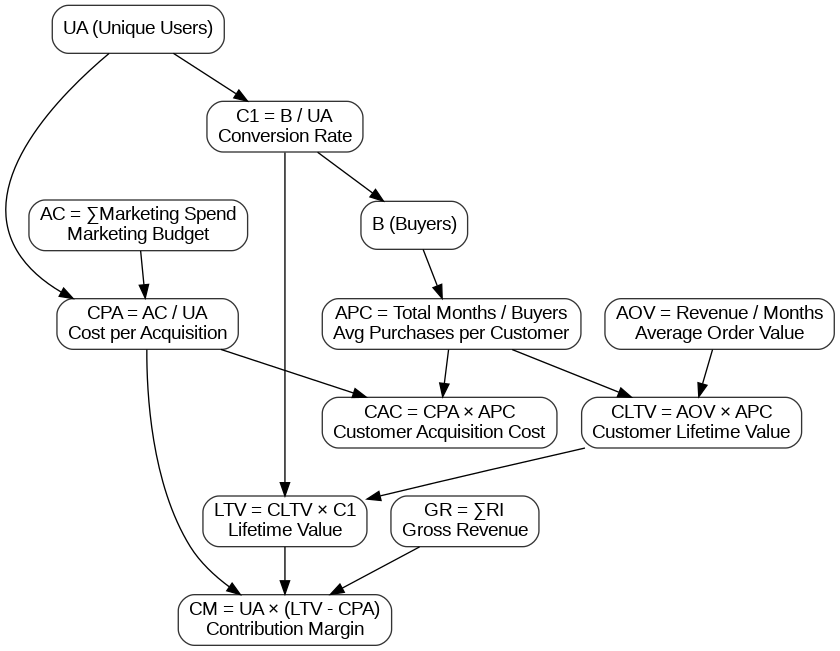

In [10]:
# Повторная инициализация после сброса среды
import graphviz

# Создаем визуальное дерево метрик с формулами
dot = graphviz.Digraph(format='png')
dot.attr(rankdir='TB', size='10')

# ВАЖНО: вот сюда ↓↓↓
dot.attr('node', shape='box', style='rounded,filled', fillcolor='white', color='gray20', fontname='Arial')
dot.attr('graph', style='dashed',color='gray50')

# Узлы верхнего уровня
dot.node('UA', 'UA (Unique Users)')
dot.node('C1', 'C1 = B / UA\nConversion Rate')
dot.node('B', 'B (Buyers)')
dot.node('AC', 'AC = ∑Marketing Spend\nMarketing Budget')
dot.node('CPA', 'CPA = AC / UA\nCost per Acquisition')

# LTV блок
dot.node('AOV', 'AOV = Revenue / Months\nAverage Order Value')
dot.node('APC', 'APC = Total Months / Buyers\nAvg Purchases per Customer')
dot.node('CLTV', 'CLTV = AOV × APC\nCustomer Lifetime Value')
dot.node('LTV', 'LTV = CLTV × C1\nLifetime Value')
dot.node('CAC', 'CAC = CPA × APC\nCustomer Acquisition Cost')

# CM и доход
dot.node('CM', 'CM = UA × (LTV - CPA)\nContribution Margin')
dot.node('GR', 'GR = ∑RI\nGross Revenue')

# Связи
dot.edges([('UA', 'C1'), ('C1', 'B'), ('UA', 'CPA'), ('CPA', 'CAC'), ('AC', 'CPA')])
dot.edge('B', 'APC')
dot.edge('AOV', 'CLTV')
dot.edge('APC', 'CLTV')
dot.edge('CLTV', 'LTV')
dot.edge('C1', 'LTV')
dot.edge('LTV', 'CM')
dot.edge('CPA', 'CM')
dot.edge('APC', 'CAC')
dot.edge('GR', 'CM')

# Визуализация
dot.render('/mnt/data/unit_economy_tree', cleanup=False)
from IPython.display import Image
Image('/mnt/data/unit_economy_tree.png')


In [11]:
# Таблица гипотез
hypotheses_data = [
    {
        "Направление": "Увеличение AOV",
        "Гипотеза": "Апсейлы и кросс-сейлы увеличат средний чек",
        "Тест": "Премиум-пакеты, скидки на второй товар",
        "Потенциальный эффект": "Высокий",
        "Сложность реализации": "Средняя",
        "Приоритет": "Высокий"
    },
    {
        "Направление": "Улучшение конверсии (C1)",
        "Гипотеза": "Оптимизация лендингов и креативов увеличит конверсию",
        "Тест": "A/B тестирование лендингов и рекламных сообщений",
        "Потенциальный эффект": "Средний",
        "Сложность реализации": "Низкая",
        "Приоритет": "Средний"
    },
    {
        "Направление": "Снижение CPA",
        "Гипотеза": "Анализ каналов и перераспределение бюджета снизит CPA",
        "Тест": "Отключение неэффективных каналов, усиление прибыльных",
        "Потенциальный эффект": "Средний",
        "Сложность реализации": "Низкая",
        "Приоритет": "Средний"
    },
    {
        "Направление": "Увеличение APC",
        "Гипотеза": "Улучшение опыта и сервиса увеличит повторные покупки",
        "Тест": "Программа лояльности, персонализированные предложения",
        "Потенциальный эффект": "Высокий",
        "Сложность реализации": "Средняя",
        "Приоритет": "Высокий"
    }
]

df_hypotheses = pd.DataFrame(hypotheses_data)
df_hypotheses


,Направление,Гипотеза,Тест,Потенциальный эффект,Сложность реализации,Приоритет
0,Увеличение AOV,Апсейлы и кросс-сейлы увеличат средний чек,"Премиум-пакеты, скидки на второй товар",Высокий,Средняя,Высокий
1,Улучшение конверсии (C1),Оптимизация лендингов и креативов увеличит кон...,A/B тестирование лендингов и рекламных сообщений,Средний,Низкая,Средний
2,Снижение CPA,Анализ каналов и перераспределение бюджета сни...,"Отключение неэффективных каналов, усиление при...",Средний,Низкая,Средний
3,Увеличение APC,Улучшение опыта и сервиса увеличит повторные п...,"Программа лояльности, персонализированные пред...",Высокий,Средняя,Высокий


In [12]:
# Исходные параметры
p = 0.1713          # базовая конверсия (C1)
x = 0.01            # ожидаемый прирост (абсолютный)
total_traffic = 11288
days = 30

# Событий в день
events_per_day = total_traffic / days

# Размер выборки на группу
n = (16 * p * (1 - p)) / (x ** 2)

# Время теста в днях для одной группы
test_duration_days = n / events_per_day

# Округление и вывод
result_df = pd.DataFrame({
    "Базовая конверсия (p)": [p],
    "Ожидаемый прирост (x)": [x],
    "Размер выборки (на группу)": [round(n)],
    "Событий в день": [round(events_per_day)],
    "Время теста (в днях)": [round(test_duration_days, 1)]
})

result_df

,Базовая конверсия (p),Ожидаемый прирост (x),Размер выборки (на группу),Событий в день,Время теста (в днях)
0,0.1713,0.01,22713,376,60.4
